# 数据规整化：清理、转换、合并、重塑

In [191]:
%matplotlib inline
#使图片内嵌交互环境显示
import numpy as np
from pandas import Series,DataFrame
import pandas as pd
import matplotlib.pyplot as plt

## 合并数据集

### 数据库风格的DataFrame合并

In [192]:
# pandas 的 merge 函数
df1 = DataFrame({'key':['b','b','a','c','a','a','b'],
                'data1':range(7)})
df1

,data1,key
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,a
6,6,b


In [193]:
df2 = DataFrame({'key':['a','b','d'],
                'data2':range(3)})
df2

,data2,key
0,0,a
1,1,b
2,2,d


In [194]:
# 这是一种多对一的合并：
    # df1 多个被标记为a、b的行
    # df2 key列每个值则仅对应一行
    
pd.merge(df1,df2) # 如果没有指定用哪个列进行连接，merge就会将重叠列的列名当做键

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0


In [195]:
pd.merge(df1,df2,on='key') # 最好显示的指定一下连接的键

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0


In [196]:
df3 = DataFrame({'lkey':list('bbacaab'),
                'data1':range(7)})
df3

,data1,lkey
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,a
6,6,b


In [197]:
df4 = DataFrame({'rkey':list('abd'),
                'data2':range(3)})
df4

,data2,rkey
0,0,a
1,1,b
2,2,d


In [198]:
pd.merge(df3,df4,left_on = 'lkey',right_on = 'rkey') # 可以分别指定连接的键

,data1,lkey,data2,rkey
0,0,b,1,b
1,1,b,1,b
2,6,b,1,b
3,2,a,0,a
4,4,a,0,a
5,5,a,0,a


In [199]:
# 默认情况下 merge 做的是‘inner’连接，结果中的键是交集
# 其他连接方式还有：‘left’‘right’‘outer’
pd.merge(df1,df2,how = 'outer') # 'outer' 外链求的是并集

,data1,key,data2
0,0.0,b,1.0
1,1.0,b,1.0
2,6.0,b,1.0
3,2.0,a,0.0
4,4.0,a,0.0
5,5.0,a,0.0
6,3.0,c,NaN
7,NaN,d,2.0


In [200]:
# 多对多的合并操作 -- 产生的是行的笛卡尔积（左边有3个b，右边有2个b，结果有6个b）
df1 = DataFrame({'key':list('bbacab'),
                'data1':range(6)})
df1

,data1,key
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,b


In [201]:
df2 = DataFrame({'key':list('ababd'),
                'data2':range(5)})
df2

,data2,key
0,0,a
1,1,b
2,2,a
3,3,b
4,4,d


In [202]:
pd.merge(df1,df2,on='key',how='left')

,data1,key,data2
0,0,b,1.0
1,0,b,3.0
2,1,b,1.0
3,1,b,3.0
4,2,a,0.0
5,2,a,2.0
6,3,c,NaN
7,4,a,0.0
8,4,a,2.0
9,5,b,1.0


In [203]:
pd.merge(df1,df2,how = 'inner')

,data1,key,data2
0,0,b,1
1,0,b,3
2,1,b,1
3,1,b,3
4,5,b,1
5,5,b,3
6,2,a,0
7,2,a,2
8,4,a,0
9,4,a,2


In [204]:
# 根据多个键进行合并 
    # 可以这样理解：多个键组成一系列元祖，并将其结果当做单个键
left = DataFrame({'key1':['foo','foo','bar'],
                 'key2':['one','two','three'],
                 'lval':[1,2,3]})
left

,key1,key2,lval
0,foo,one,1
1,foo,two,2
2,bar,three,3


In [205]:
right = DataFrame({'key1':['foo','foo','bar','bar'],
                  'key2':['one','one','one','two'],
                  'rval':[4,5,6,7]})
right

,key1,key2,rval
0,foo,one,4
1,foo,one,5
2,bar,one,6
3,bar,two,7


In [206]:
pd.merge(left,right,on=['key1','key2'],how = 'outer')

,key1,key2,lval,rval
0,foo,one,1.0,4.0
1,foo,one,1.0,5.0
2,foo,two,2.0,NaN
3,bar,three,3.0,NaN
4,bar,one,NaN,6.0
5,bar,two,NaN,7.0


In [207]:
# 重复列名的处理
pd.merge(left,right,on = 'key1') # 默认情况下

,key1,key2_x,lval,key2_y,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,three,3,one,6
5,bar,three,3,two,7


In [208]:
pd.merge(left,right,on = 'key1',suffixes = ('_左','_右')) #修改重复列备注

,key1,key2_左,lval,key2_右,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,three,3,one,6
5,bar,three,3,two,7


In [209]:
%%html
<img src = 'pic\merge函数的参数.png'>

### 索引上的合并

In [210]:
# 有时候链接键位于其索引中
left1 = DataFrame({'key':list('abaabc'),
                  'value':range(6)})
left1

,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [211]:
right1 = DataFrame({'group_val':[3.5,7]},index = ['a','b'])
right1

,group_val
a,3.5
b,7.0


In [212]:
pd.merge(left1, right1, left_on = 'key',right_index = True) # 右边用索引作为键

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0


In [213]:
# 层次化索引--合并
lefth = DataFrame({'key1':['Ohio','Ohio','Ohio','Nevada','Nevada'],
                  'key2':[2000,2001,2002,2001,2002],
                  'data':np.arange(5.)})
lefth

,data,key1,key2
0,0.0,Ohio,2000
1,1.0,Ohio,2001
2,2.0,Ohio,2002
3,3.0,Nevada,2001
4,4.0,Nevada,2002


In [214]:
righth = DataFrame(np.arange(12).reshape(6,2),
                  index = [['Nevada','Nevada','Ohio','Ohio','Ohio','Ohio'],
                          [2001,2000,2000,2000,2001,2002]],
                  columns = ['event1','event2'])
righth

event1  event2
Nevada 2001       0       1
       2000       2       3
Ohio   2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

In [215]:
pd.merge(lefth,righth,left_on = ['key1','key2'],right_index = True)

,data,key1,key2,event1,event2
0,0.0,Ohio,2000,4,5
0,0.0,Ohio,2000,6,7
1,1.0,Ohio,2001,8,9
2,2.0,Ohio,2002,10,11
3,3.0,Nevada,2001,0,1


In [216]:
# 同时使用双方的索引
left2 = DataFrame([[1.,2.],[3.,4.],[5.,6.]],
                  index = ['a','c','e'],
                  columns = ['Ohio','Nevada'])
left2

,Ohio,Nevada
a,1.0,2.0
c,3.0,4.0
e,5.0,6.0


In [217]:
right2 = DataFrame([[7.,8.],[9.,10.],[11.,12.],[13.,14.]],
                  index = list('bcde'),
                  columns = ['Missouri','Alabama'])
right2

,Missouri,Alabama
b,7.0,8.0
c,9.0,10.0
d,11.0,12.0
e,13.0,14.0


In [218]:
pd.merge(left2,right2,how = 'outer',left_index = True, right_index = True) # 同时使用两个索引

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


In [219]:
# DataFrame还有一个 join 实例方法，同样可以实现索引合并
# 默认把索引当键
# join做左连接
left2.join(right2,how = 'outer')

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


In [220]:
left1.join(right1,on = 'key') # 可以设置调用者的某个列（left1）作为连接

,key,value,group_val
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0
5,c,5,NaN


In [221]:
# join方法还支持传入一组DataFrame
another = DataFrame([[7.,8.],[9.,10.],[11.,12.],[16.,17.]],
                   index = list('acef'),
                   columns = ['New York','Oregon'])
another

,New York,Oregon
a,7.0,8.0
c,9.0,10.0
e,11.0,12.0
f,16.0,17.0


In [222]:
left2.join([right2,another])

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0,9.0,10.0
e,5.0,6.0,13.0,14.0,11.0,12.0


### 轴向连接

In [223]:
# pandas 的concat函数
s1 = Series([0,1],index = ['a','b'])
s1

a    0
b    1
dtype: int64

In [224]:
s2 = Series([2,3,4],index = ['c','d','e'])
s2

c    2
d    3
e    4
dtype: int64

In [225]:
s3 = Series([5,6],index = ['f','g'])
s3

f    5
g    6
dtype: int64

In [226]:
# concat 可以将值和索引粘合在一起
pd.concat([s1,s2,s3]) # 默认情况下 concat 实在 axis = 0上工作的

a    0
b    1
c    2
d    3
e    4
f    5
g    6
dtype: int64

In [227]:
pd.concat([s1,s2,s3],axis = 1) # 在axis=1列上；是并集

,0,1,2
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


In [228]:
s4 = pd.concat([s1*5,s3])
s4

a    0
b    5
f    5
g    6
dtype: int64

In [229]:
pd.concat([s1,s4],axis = 1)

,0,1
a,0.0,0
b,1.0,5
f,NaN,5
g,NaN,6


In [230]:
pd.concat([s1,s4],axis = 1,join = 'inner')

,0,1
a,0,0
b,1,5


In [231]:
# 通过join_axes 指定在其他轴上使用的索引：
pd.concat([s1,s4],axis = 1,join_axes = [list('acbe')])

,0,1
a,0.0,0.0
c,NaN,NaN
b,1.0,5.0
e,NaN,NaN


In [232]:
# 在连接轴上创建一个层次化索引（区分参与连接的片段--取名字）
result = pd.concat([s1,s1,s3],keys = ['one','two','three'])
result

one    a    0
       b    1
two    a    0
       b    1
three  f    5
       g    6
dtype: int64

In [233]:
result.unstack()

,a,b,f,g
one,0.0,1.0,NaN,NaN
two,0.0,1.0,NaN,NaN
three,NaN,NaN,5.0,6.0


In [234]:
pd.concat([s1,s2,s3],axis = 1,keys = ['one','two','three'])

,one,two,three
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


In [235]:
# 同样的逻辑对DataFrame对象也是一样：
df1 = DataFrame(np.arange(6).reshape(3,2),
               index = ['a','b','c'],
               columns = ['one','two'])
df1

,one,two
a,0,1
b,2,3
c,4,5


In [236]:
df2 = DataFrame( 5 + np.arange(4).reshape(2,2),
               index = ['a','c'],
               columns = ['three','four'])
df2

,three,four
a,5,6
c,7,8


In [237]:
pd.concat([df1,df2],axis = 1,keys = ['level1','level2'])

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

In [238]:
pd.concat([df1,df2],keys = ['level1','level2'])

four  one  three  two
level1 a   NaN  0.0    NaN  1.0
       b   NaN  2.0    NaN  3.0
       c   NaN  4.0    NaN  5.0
level2 a   6.0  NaN    5.0  NaN
       c   8.0  NaN    7.0  NaN

In [239]:
# 传入字典，合并
pd.concat({'level1':df1,'level2':df2},axis = 1)

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

In [240]:
pd.concat([df1,df2],axis = 1,keys = ['level1','level2'],names = ['upper','lower'])

upper level1     level2     
lower    one two  three four
a          0   1    5.0  6.0
b          2   3    NaN  NaN
c          4   5    7.0  8.0

In [241]:
# 去除行索引
df1 = DataFrame(np.random.randn(3,4),columns = list('abcd'))
df1

,a,b,c,d
0,0.324968,0.203775,0.348862,0.516009
1,-0.489821,-0.628746,0.266415,1.083685
2,0.303349,-1.107238,-0.976152,-2.132725


In [242]:
df2 = DataFrame(np.random.randn(2,3),columns = list('bda'))
df2

,b,d,a
0,0.542522,-0.225276,2.750476
1,1.703181,-0.491991,-1.021350


In [243]:
pd.concat([df1,df2])

,a,b,c,d
0,0.324968,0.203775,0.348862,0.516009
1,-0.489821,-0.628746,0.266415,1.083685
2,0.303349,-1.107238,-0.976152,-2.132725
0,2.750476,0.542522,NaN,-0.225276
1,-1.021350,1.703181,NaN,-0.491991


In [244]:
pd.concat([df1,df2],ignore_index = True) #抛弃原行索引，自动配置新索引

,a,b,c,d
0,0.324968,0.203775,0.348862,0.516009
1,-0.489821,-0.628746,0.266415,1.083685
2,0.303349,-1.107238,-0.976152,-2.132725
3,2.750476,0.542522,NaN,-0.225276
4,-1.021350,1.703181,NaN,-0.491991


In [245]:
%%html
<img src = 'pic\concat函数的参数.png'>

### 合并重叠数据

In [246]:
# 还有一种数据组合问题不能用简单的合并或连接处理
# 比如：可能有索引全部或部分重叠的两个数据集
a = Series([np.nan,2.5,np.nan,3.5,4.5,np.nan],
          index = ['f','e','d','c','b','a'])
a

f    NaN
e    2.5
d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64

In [247]:
b = Series(np.arange(len(a),dtype = np.float64),
          index = ['f','e','d','c','b','a'])
b[-1] = np.nan
b

f    0.0
e    1.0
d    2.0
c    3.0
b    4.0
a    NaN
dtype: float64

In [248]:
# 示例：我们使用NumPy的where函数，它用于表达一种矢量化的if-else
np.where(pd.isnull(a),b,a)

array([ 0. ,  2.5,  2. ,  3.5,  4.5,  nan])

In [249]:
# Series有一个combine_first方法，实现同样功能，且会进行数据对齐
b[:-2].combine_first(a[2:])

a    NaN
b    4.5
c    3.0
d    2.0
e    1.0
f    0.0
dtype: float64

In [250]:
# 对于DataFrame，combine_first会做同样的事情
    # 即：用参数对象中的数据为调用者对象的缺失数据“打补丁”
df1 = DataFrame({'a':[1.,np.nan,5.,np.nan],
                'b':[np.nan,2.,np.nan,6.],
                'c':range(2,18,4)})
df1

,a,b,c
0,1.0,NaN,2
1,NaN,2.0,6
2,5.0,NaN,10
3,NaN,6.0,14


In [251]:
df2 = DataFrame({'a':[5.,4,np.nan,3.,7],
                'b':[np.nan,3.,4,6.,8]})
df2

,a,b
0,5.0,NaN
1,4.0,3.0
2,NaN,4.0
3,3.0,6.0
4,7.0,8.0


In [252]:
df1.combine_first(df2)

,a,b,c
0,1.0,NaN,2.0
1,4.0,2.0,6.0
2,5.0,4.0,10.0
3,3.0,6.0,14.0
4,7.0,8.0,NaN


## 重塑和轴向旋转

### 重塑层次化索引

In [253]:
# 层次化索引为DataFrame数据的重排任务提供了一种具有良好一致性的方式，主要功能有二：
    # stack：将数据的列“旋转”为行
    # unstack：将数据的行“旋转”为列
data = DataFrame(np.arange(6).reshape((2,3)),
                index = pd.Index(['Ohio','Colorado'],name = 'state'),
                columns = pd.Index(['one','two','three'],name = 'number'))
data

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


In [254]:
# 使用stack方法，将数据的列转换为行：
result = data.stack()
result

state     number
Ohio      one       0
          two       1
          three     2
Colorado  one       3
          two       4
          three     5
dtype: int32

In [255]:
# 对于一个层次化索引的Series，你可以用unstack将其重排为一个DataFrame：
result.unstack()

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


In [256]:
# 默认情况下stack、unstack操作的是最内层，可以通过传入编号、名称修改
result.unstack(0)

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


In [257]:
result.unstack('state')

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


In [258]:
# 如果不是所有的级别值都能在各分组中找到的话，则unstack可能会引入缺失数据：
s1 = Series([0,1,2,3],index = ['a','b','c','d'])
s1

a    0
b    1
c    2
d    3
dtype: int64

In [259]:
s2 = Series([4,5,6],index = ['c','d','e'])
s2

c    4
d    5
e    6
dtype: int64

In [260]:
data2 = pd.concat([s1,s2],keys = ['one','two'])
data2

one  a    0
     b    1
     c    2
     d    3
two  c    4
     d    5
     e    6
dtype: int64

In [261]:
data2.unstack()

,a,b,c,d,e
one,0.0,1.0,2.0,3.0,NaN
two,NaN,NaN,4.0,5.0,6.0


In [262]:
# stack默认会滤除缺失数据，因此该运算是可逆的：
data2.unstack().stack()

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
two  c    4.0
     d    5.0
     e    6.0
dtype: float64

In [263]:
data2.unstack().stack(dropna = False)

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
     e    NaN
two  a    NaN
     b    NaN
     c    4.0
     d    5.0
     e    6.0
dtype: float64

In [264]:
# 在对DataFrame进行unstack操作时，作为旋转轴的级别将会成为最低级别
df = DataFrame({'left':result,'right':result+5},
              columns = pd.Index(['left','right'],name='side'))
df

side             left  right
state    number             
Ohio     one        0      5
         two        1      6
         three      2      7
Colorado one        3      8
         two        4      9
         three      5     10

In [265]:
df.unstack('state')

side   left          right         
state  Ohio Colorado  Ohio Colorado
number                             
one       0        3     5        8
two       1        4     6        9
three     2        5     7       10

In [266]:
df.unstack('state').stack('side')

state         Colorado  Ohio
number side                 
one    left          3     0
       right         8     5
two    left          4     1
       right         9     6
three  left          5     2
       right        10     7

### 将“长格式”旋转为“宽格式”

In [267]:
# 先准备“ldata”数据
csv_data = pd.read_csv('ch07\macrodata.csv')
csv_data[:5]

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [268]:
periods = pd.PeriodIndex(year = csv_data.year,quarter = csv_data.quarter,name = 'date')
periods

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', name='date', length=203, freq='Q-DEC')

In [269]:
data = DataFrame(data.to_records(),
                columns = pd.Index(['realgdp','infl','unemp'],name = 'item'),
                index = periods.to_timestamp('D','end'))
data[:5]

item,realgdp,infl,unemp
date,,,
1959-03-31,NaN,NaN,NaN
1959-06-30,NaN,NaN,NaN
1959-09-30,NaN,NaN,NaN
1959-12-31,NaN,NaN,NaN
1960-03-31,NaN,NaN,NaN


In [270]:
ldata = data.stack().reset_index().rename(columns = {0:'value'})
ldata[:6] 
# 数据库一般都是ldata这种类型的，即date和item作为键，后面value存储值
# 这样有一个好处：item的类型可以自由增减
# 也有缺点：数据操作起来可能不那么轻松

,date,item,value


In [271]:
pivoted = ldata.pivot('date','item','value') # 前两个参数值分别用作行和列索引的列名，最后一个参数值则是用于填充。
pivoted.head()

item
date


In [272]:
# 假设有两个需要参与重塑的数据列
ldata['value2'] = np.random.randn(len(ldata))
ldata.head()

,date,item,value,value2


In [273]:
# 忽略最后一个参数，得到的DataFrame就会得到层次化索引的列
pivoted = ldata.pivot('date','item')
pivoted.head()

date


In [274]:
# 注意：其实pivot其实只是一个快捷方式而已：用set_index创建层次化索引，再用unstack重塑
unstacked = ldata.set_index(['date','item']).unstack('item')
unstacked.head()

date


## 数据转换

### 移除重复数据

In [275]:
data = DataFrame({'k1':['one']*3 + ['two']*4,
                 'k2':[1,1,2,3,3,4,4]})
data

,k1,k2
0,one,1
1,one,1
2,one,2
3,two,3
4,two,3
5,two,4
6,two,4


In [276]:
# DataFrame的duplicated方法返回一个布尔型Series，表示各行是否是重复行
data.duplicated()

0    False
1     True
2    False
3    False
4     True
5    False
6     True
dtype: bool

In [277]:
# drop_duplicated方法，它用于返回一个移除了重复行的DataFrame
data.drop_duplicates()

,k1,k2
0,one,1
2,one,2
3,two,3
5,two,4


In [278]:
# 这两个方法默认会把全部列作为一个判断依据。可以指定部分列进行重复项判断
data['v1'] = range(7)
data

,k1,k2,v1
0,one,1,0
1,one,1,1
2,one,2,2
3,two,3,3
4,two,3,4
5,two,4,5
6,two,4,6


In [279]:
data.drop_duplicates(['k1']) #默认保留第一个出现的值的组合（传入take_last = True则保留最后一个）

,k1,k2,v1
0,one,1,0
3,two,3,3


### 利用函数或映射进行数据转换

In [280]:
data = DataFrame({'food':['bacon','pulled pork','bacon','Pastrami','corned beef','Bacon','pastrami','honey ham','nova lox'],
                 'ounces':[4,3,12,6,7.5,8,3,5,6]})
data

,food,ounces
0,bacon,4.0
1,pulled pork,3.0
2,bacon,12.0
3,Pastrami,6.0
4,corned beef,7.5
5,Bacon,8.0
6,pastrami,3.0
7,honey ham,5.0
8,nova lox,6.0


In [281]:
# 目标：添加一列表示该肉类食物来源的动物类型
# 先编写一个肉类到动物的映射
meat_to_animal = {
    'bacon':'pig',
    'pulled pork':'pig',
    'pastrami':'cow',
    'corned beef':'cow',
    'honey ham':'pig',
    'nova lox':'salmon'
}

In [282]:
# Series 的map方法可以接受一个 函数 或 含有映射关系的字典型对象
data['animal'] = data['food'].map(str.lower).map(meat_to_animal)
data

,food,ounces,animal
0,bacon,4.0,pig
1,pulled pork,3.0,pig
2,bacon,12.0,pig
3,Pastrami,6.0,cow
4,corned beef,7.5,cow
5,Bacon,8.0,pig
6,pastrami,3.0,cow
7,honey ham,5.0,pig
8,nova lox,6.0,salmon


In [283]:
# 也可以用一个函数实现上述功能
data['food'].map(lambda x:meat_to_animal[x.lower()])

0       pig
1       pig
2       pig
3       cow
4       cow
5       pig
6       cow
7       pig
8    salmon
Name: food, dtype: object

### 替换值

In [284]:
# 前面提到的map可用于修改对象的数据子集，而replace则提供了一种实现该功能的更简单、更灵活的方式
data = Series([1.,-999,2.,-999,-1000,3.])
data

0       1.0
1    -999.0
2       2.0
3    -999.0
4   -1000.0
5       3.0
dtype: float64

In [285]:
# -999这个值可能是一个缺失数据的标记值，要将其替换为pandas能理解的NA值，我们可以利用replace
data.replace(-999,np.nan)

0       1.0
1       NaN
2       2.0
3       NaN
4   -1000.0
5       3.0
dtype: float64

In [286]:
# 可以一次性替换多个值
data.replace([-999,-1000],np.nan)

0    1.0
1    NaN
2    2.0
3    NaN
4    NaN
5    3.0
dtype: float64

In [287]:
# 可以对不同的值进行不同的替换
data.replace([-999,-1000],[np.nan,0])

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

In [288]:
# 也可以使用字典
data.replace({-999:np.nan,-1000:0})

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

### 重命名轴索引

In [289]:
data=DataFrame(np.arange(12).reshape((3,4)),
               index=['Ohio', 'Colorado', 'New York'],
               columns=['one', 'two', 'three', 'four'])
data

,one,two,three,four
Ohio,0,1,2,3
Colorado,4,5,6,7
New York,8,9,10,11


In [290]:
data.index.map(str.upper)

Index(['OHIO', 'COLORADO', 'NEW YORK'], dtype='object')

In [291]:
data.index = data.index.map(str.upper)
data

,one,two,three,four
OHIO,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


In [292]:
# 创建数据集的转换版（而不是修改原始数据），比较实用的方法是rename
data.rename(index=str.title,columns = str.upper)

,ONE,TWO,THREE,FOUR
Ohio,0,1,2,3
Colorado,4,5,6,7
New York,8,9,10,11


In [293]:
data

,one,two,three,four
OHIO,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


In [294]:
# rename可以对部分轴标签的更新：
data.rename(index = {'OHIO':'INDIANA'},
           columns = {'three':'peekaboo'})

,one,two,peekaboo,four
INDIANA,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


In [295]:
data

,one,two,three,four
OHIO,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


In [296]:
# 如果希望就地修改某个数据集，传入replace=True即可：
_ = data.rename(index = {'OHIO':'INDIANA'},inplace = True)

In [297]:
data

,one,two,three,four
INDIANA,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


### 离散化和面元划分

In [298]:
# 为了便于分析，连续数据常常被离散化或拆分为“面元”
ages = [20,22,25,27,21,23,37,31,61,45,41,32]
ages

[20, 22, 25, 27, 21, 23, 37, 31, 61, 45, 41, 32]

In [299]:
#设置划分依据，并划分面元
bins = [18,25,35,60,100]
cats = pd.cut(ages,bins)
cats

[(18, 25], (18, 25], (18, 25], (25, 35], (18, 25], ..., (25, 35], (60, 100], (35, 60], (35, 60], (25, 35]]
Length: 12
Categories (4, interval[int64]): [(18, 25] < (25, 35] < (35, 60] < (60, 100]]

In [300]:
# pandas返回的是一个特殊的Categorical对象
# 这个对象有一个codes属性：
cats.codes

array([0, 0, 0, 1, 0, 0, 2, 1, 3, 2, 2, 1], dtype=int8)

In [301]:
cats.categories

IntervalIndex([(18, 25], (25, 35], (35, 60], (60, 100]]
              closed='right',
              dtype='interval[int64]')

In [302]:
pd.value_counts(cats)

(18, 25]     5
(35, 60]     3
(25, 35]     3
(60, 100]    1
dtype: int64

In [303]:
# 这个区间中，圆括号表示开端，方括号表示闭端（包括）
# 可以通过right=False进行修改
pd.cut(ages,bins,right=False)

[[18, 25), [18, 25), [25, 35), [25, 35), [18, 25), ..., [25, 35), [60, 100), [35, 60), [35, 60), [25, 35)]
Length: 12
Categories (4, interval[int64]): [[18, 25) < [25, 35) < [35, 60) < [60, 100)]

In [304]:
# 可以设置面元名称
group_names = ['Youth','YoungAdult','MiddleAged','Senior']
pd.cut(ages,bins,labels = group_names)

[Youth, Youth, Youth, YoungAdult, Youth, ..., YoungAdult, Senior, MiddleAged, MiddleAged, YoungAdult]
Length: 12
Categories (4, object): [Youth < YoungAdult < MiddleAged < Senior]

In [305]:
# 向cuts传入面元的数量，而不是面元边界，那么会自动计算等长面元
data = np.random.rand(20)
data

array([ 0.1083731 ,  0.9276808 ,  0.18307257,  0.13446399,  0.8195306 ,
        0.88401981,  0.25354715,  0.58577873,  0.74213703,  0.06344072,
        0.66894584,  0.44300707,  0.99955133,  0.04958322,  0.62787667,
        0.04533641,  0.59105674,  0.63299761,  0.30445838,  0.57649255])

In [306]:
pd.cut(data,4,precision = 2) # precision表示精度

[(0.044, 0.28], (0.76, 1.0], (0.044, 0.28], (0.044, 0.28], (0.76, 1.0], ..., (0.044, 0.28], (0.52, 0.76], (0.52, 0.76], (0.28, 0.52], (0.52, 0.76]]
Length: 20
Categories (4, interval[float64]): [(0.044, 0.28] < (0.28, 0.52] < (0.52, 0.76] < (0.76, 1.0]]

In [307]:
# qcut非常类似cut，但是分割是用的样本分位数，因此内含数据点数量一样
data = np.random.randn(1000) # 正太分布
cats = pd.qcut(data,4) # 按四分位数进行分割

In [308]:
cats

[(-0.0259, 0.677], (-3.441, -0.723], (-0.0259, 0.677], (-0.723, -0.0259], (-0.0259, 0.677], ..., (-0.0259, 0.677], (-3.441, -0.723], (0.677, 3.424], (0.677, 3.424], (-0.0259, 0.677]]
Length: 1000
Categories (4, interval[float64]): [(-3.441, -0.723] < (-0.723, -0.0259] < (-0.0259, 0.677] < (0.677, 3.424]]

In [309]:
pd.value_counts(cats)

(0.677, 3.424]       250
(-0.0259, 0.677]     250
(-0.723, -0.0259]    250
(-3.441, -0.723]     250
dtype: int64

In [310]:
# 跟cut一样，也可以设置自定义分位数（0到1之间的数值，包含端点）：
cats2 = pd.qcut(data,[0,0.1,0.5,0.9,1.])

In [311]:
cats2

[(-0.0259, 1.283], (-1.347, -0.0259], (-0.0259, 1.283], (-1.347, -0.0259], (-0.0259, 1.283], ..., (-0.0259, 1.283], (-3.441, -1.347], (-0.0259, 1.283], (1.283, 3.424], (-0.0259, 1.283]]
Length: 1000
Categories (4, interval[float64]): [(-3.441, -1.347] < (-1.347, -0.0259] < (-0.0259, 1.283] < (1.283, 3.424]]

In [312]:
pd.value_counts(cats2)

(-0.0259, 1.283]     400
(-1.347, -0.0259]    400
(1.283, 3.424]       100
(-3.441, -1.347]     100
dtype: int64

### 检测和过滤异常值

In [313]:
# 异常值的过滤或变换运算在很大程度上其实就是数组运算
np.random.seed(12345)
# seed( ) 用于指定随机数生成时所用算法开始的整数值，如果使用相同的seed( )值，则每次生成的随即数都相同，
# 如果不设置这个值，则系统根据时间来自己选择这个值，此时每次生成的随机数因时间差异而不同。

In [314]:
data = DataFrame(np.random.randn(1000,4))
data.head()

,0,1,2,3
0,-0.204708,0.478943,-0.519439,-0.555730
1,1.965781,1.393406,0.092908,0.281746
2,0.769023,1.246435,1.007189,-1.296221
3,0.274992,0.228913,1.352917,0.886429
4,-2.001637,-0.371843,1.669025,-0.438570


In [315]:
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.067684,0.067924,0.025598,-0.002298
std,0.998035,0.992106,1.006835,0.996794
min,-3.428254,-3.548824,-3.184377,-3.745356
25%,-0.774890,-0.591841,-0.641675,-0.644144
50%,-0.116401,0.101143,0.002073,-0.013611
75%,0.616366,0.780282,0.680391,0.654328
max,3.366626,2.653656,3.260383,3.927528


In [316]:
# 假设你想找出某列中绝对值大小超过3的值：
col = data[3]
col[np.abs(col) > 3]

97     3.927528
305   -3.399312
400   -3.745356
Name: 3, dtype: float64

In [317]:
# 如果想要选出全部含有“超过3或-3的值”的行，你可以利用布尔型DataFrame以及any方法
data[(np.abs(data)>3).any(1)]

,0,1,2,3
5,-0.539741,0.476985,3.248944,-1.021228
97,-0.774363,0.552936,0.106061,3.927528
102,-0.655054,-0.565230,3.176873,0.959533
305,-2.315555,0.457246,-0.025907,-3.399312
324,0.050188,1.951312,3.260383,0.963301
400,0.146326,0.508391,-0.196713,-3.745356
499,-0.293333,-0.242459,-3.056990,1.918403
523,-3.428254,-0.296336,-0.439938,-0.867165
586,0.275144,1.179227,-3.184377,1.369891
808,-0.362528,-3.548824,1.553205,-2.186301


In [318]:
# 根据这些条件可轻松地对值进行设置
data[np.abs(data)>3] = np.sign(data)*3 # sign返回-1,0,1
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.067623,0.068473,0.025153,-0.002081
std,0.995485,0.990253,1.003977,0.989736
min,-3.000000,-3.000000,-3.000000,-3.000000
25%,-0.774890,-0.591841,-0.641675,-0.644144
50%,-0.116401,0.101143,0.002073,-0.013611
75%,0.616366,0.780282,0.680391,0.654328
max,3.000000,2.653656,3.000000,3.000000


### 排列和随机采样

In [319]:
# 利用numpy.random.permutation函数可以轻松实现对Series或DataFrame的列的排列工作（permuting，随机重排序）。
df = DataFrame(np.arange(5*4).reshape(5,4))
df

,0,1,2,3
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In [320]:
sampler = np.random.permutation(5)
sampler

array([1, 0, 2, 3, 4])

In [321]:
# 然后就可以基于ix的索引操作或take函数中使用该数组了：
df

,0,1,2,3
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In [322]:
df.take(sampler)

,0,1,2,3
1,4,5,6,7
0,0,1,2,3
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In [323]:
#如果不想用替换的方式选取随机子集，则可以使用permutation：从permutation返回的数组中切下前k个元素，其中k为期望的子集大小。
df.take(np.random.permutation(len(df))[:3])

,0,1,2,3
1,4,5,6,7
3,12,13,14,15
4,16,17,18,19


In [324]:
#要通过替换的方式产生样本，最快的方式是通过np.random.randint得到一组随机整数
bag = np.array([5,7,-1,6,4])
sampler = np.random.randint(0,len(bag),size=10)
sampler

array([4, 4, 2, 2, 2, 0, 3, 0, 4, 1])

In [325]:
draws = bag.take(sampler)
draws

array([ 4,  4, -1, -1, -1,  5,  6,  5,  4,  7])

### 计算指标/哑变量

In [326]:
# 如果DataFrame的某一列中含有k个不同的值，则可以派生出一个k列矩阵或DataFrame（其值全为1和0）。
# 意思就是，原本这一行出现的是哪个数值，则这个位置对应1
df = DataFrame({'key':['b','b','a','c','a','b'],
               'data1':range(6)})
df

,data1,key
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,b


In [327]:
pd.get_dummies(df['key'])

,a,b,c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0


In [328]:
# 可以加上一个前缀
# get_dummies的prefix参数可以实现该功能：
dummies = pd.get_dummies(df['key'],prefix = 'key')
dummies

,key_a,key_b,key_c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0


In [329]:
df_with_dummy = df[['data1']].join(dummies)
df_with_dummy

,data1,key_a,key_b,key_c
0,0,0,1,0
1,1,0,1,0
2,2,1,0,0
3,3,0,0,1
4,4,1,0,0
5,5,0,1,0


In [330]:
# 如果DataFrame中的某行同属于多个分类，则会有点复杂：
mnames = ['movie_id','title','genres']
movies = pd.read_table('ch07\movielens\movies.dat',sep='::',header = None,names=mnames)
movies.head()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [331]:
# 为genres添加指标
# 首先对genres进行规整操作
genre_iter = (set(x.split('|')) for x in movies.genres) #set集合操作

In [332]:
genres = sorted(set.union(*genre_iter))

In [333]:
# 现在从全零DataFrame开始构建指标DataFrame
dummies = DataFrame(np.zeros((len(movies),len(genres))),columns=genres)
dummies.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [334]:
# 接下来，迭代每一部电影从将dummies各行的项设置为1
for i,gen in enumerate(movies.genres):
    dummies.ix[i,gen.split('|')] = 1
dummies.head()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [335]:
# 再将其与movies合并起来：
movies_windic = movies.join(dummies.add_prefix('Genre_'))
movies_windic.head()

,movie_id,title,genres,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Children's,Genre_Comedy,Genre_Crime,Genre_Documentary,...,Genre_Fantasy,Genre_Film-Noir,Genre_Horror,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller,Genre_War,Genre_Western
0,1,Toy Story (1995),Animation|Children's|Comedy,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),Comedy|Romance,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),Comedy|Drama,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),Comedy,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 字符串操作

### 字符串对象方法

#### 内置的字符串方法

In [336]:
val = 'a,b,   guido'
val

'a,b,   guido'

In [337]:
# 字符串拆分
val.split(',')

['a', 'b', '   guido']

In [338]:
# 修剪空白符
pieces = [x.strip() for x in val.split(',')]
pieces

['a', 'b', 'guido']

In [339]:
# 字符串连接
first,second,third = pieces
first + '::' + second + '::' + third

'a::b::guido'

In [340]:
# 更实用的字符串连接
'::'.join(pieces)

'a::b::guido'

In [341]:
# 定位：in、index、find
'guido' in val

True

In [342]:
val.index(',')

1

In [343]:
val.find(':')

-1

In [345]:
# index 和 find 的区别
# val.index(':') # index 找不到会报错

In [346]:
# 出现次数统计
val.count(',')

2

In [347]:
# 替换
val.replace(',','::')

'a::b::   guido'

In [348]:
val.replace(',','')

'ab   guido'

In [349]:
%%html
<img src = 'pic\Python内置的字符串方法.png'>

## 正则表达式

- Python内置的re模块负责对字符串应用正则表达式

In [350]:
import re

In [351]:
text = "foo bar\t baz \tqux"
text

'foo bar\t baz \tqux'

In [352]:
re.split('\s+',text)

['foo', 'bar', 'baz', 'qux']

- 调用re.split(‘\s+’,text)时，正则表达式会先被编译，然后再在text上调用其split方法。

你可以用re.compile自己编译regex以得到一个可重用的regex对象:

In [353]:
regex = re.compile('\s+')

In [354]:
regex.split(text)

['foo', 'bar', 'baz', 'qux']

In [355]:
# 得到所有匹配regex的模式
regex.findall(text)

[' ', '\t ', ' \t']

注意： 如果想避免正则表达式中不需要的转义（\），则可以使用原始字符串字面量如r’C:\x’（也可以编写其等价式’C:\\\x’）。

In [356]:
# match和search跟findall功能类似。
# findall返回的是字符串中所有的匹配项，而search则只返回第一个匹配项。
# match更加严格，它只匹配字符串的首部。
text = """Dave dave@google.com
Steve steve@gmail.com
Rob rob@gmail.com
Ryan ryan@yahoo.com
"""

pattern = r'[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,4}'

# re.IGNORECASE的作用是使正则表达式对大小写不敏感
regex = re.compile(pattern,flags = re.IGNORECASE)

In [357]:
regex.findall(text)

['dave@google.com', 'steve@gmail.com', 'rob@gmail.com', 'ryan@yahoo.com']

In [358]:
m = regex.search(text) # 匹配项对象告诉我们模式在原字符串中的起始和结束位置
m

<_sre.SRE_Match object; span=(5, 20), match='dave@google.com'>

In [359]:
text[m.start():m.end()]

'dave@google.com'

In [360]:
print(regex.match(text)) # regex.match则将返回None，因为它只匹配出现在字符串开头的模式

None


In [361]:
# 利用正则表达式替换：利用sub
print(regex.sub('REDACTED',text))

Dave REDACTED
Steve REDACTED
Rob REDACTED
Ryan REDACTED



In [362]:
# 找到并分割：待分段部分用圆括号括起来
pattern = r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'
regex = re.compile(pattern,flags = re.IGNORECASE)

In [363]:
m = regex.findall('yuxin.zh@foxmail.com haidao09@126.com')
m

[('yuxin.zh', 'foxmail', 'com'), ('haidao09', '126', 'com')]

In [364]:
m = regex.search('yuxin.zh@foxmail.com haidao09@126.com')
m.groups()

('yuxin.zh', 'foxmail', 'com')

In [365]:
# 高级替换：
print(regex.sub(r'姓名：\1,域名：\2,后缀：\3',text))

Dave 姓名：dave,域名：google,后缀：com
Steve 姓名：steve,域名：gmail,后缀：com
Rob 姓名：rob,域名：gmail,后缀：com
Ryan 姓名：ryan,域名：yahoo,后缀：com



In [366]:
%%html
<img src = 'pic\正则表达式方法.png'>

### pandas中矢量化的字符串函数

In [367]:
#含有字符串的列有时还含有缺失数据，清理待分析的散乱数据时，常常需要做一些字符串规整化工作。
data = {'Dave': 'dave@google.com', 'Steve': 'steve@gmail.com',
        'Rob': 'rob@gmail.com', 'Wes': np.nan}
data

{'Dave': 'dave@google.com',
 'Rob': 'rob@gmail.com',
 'Steve': 'steve@gmail.com',
 'Wes': nan}

In [368]:
data = Series(data)
data

Dave     dave@google.com
Rob        rob@gmail.com
Steve    steve@gmail.com
Wes                  NaN
dtype: object

In [369]:
data.isnull()

Dave     False
Rob      False
Steve    False
Wes       True
dtype: bool

In [370]:
# 通过data.map，所有字符串和正则表达式方法都能被应用于（传入lambda表达式或其他函数）各个值，但是如果存在NA就会报错。
# 为了解决这个问题，Series有一些能够跳过NA值的字符串操作方法。通过Series的str属性即可访问这些方法。
# 例如，我们可以通过str.contains检查各个电子邮件地址是否含有”gmail”
data.str.contains('gmail')

Dave     False
Rob       True
Steve     True
Wes        NaN
dtype: object

In [371]:
# 也可以使用正则表达式
pattern

'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\\.([A-Z]{2,4})'

In [372]:
data.str.findall(pattern,flags=re.IGNORECASE)

Dave     [(dave, google, com)]
Rob        [(rob, gmail, com)]
Steve    [(steve, gmail, com)]
Wes                        NaN
dtype: object

In [373]:
# 有两个办法可以实现矢量化的元素获取操作：
    # 一：使用str.get
    # 二：在str属性上使用索引
matches = data.str.match(pattern,flags=re.IGNORECASE)
matches

Dave     True
Rob      True
Steve    True
Wes       NaN
dtype: object

In [374]:
matches.str.get(1)

Dave    NaN
Rob     NaN
Steve   NaN
Wes     NaN
dtype: float64

In [375]:
data.str[:5]

Dave     dave@
Rob      rob@g
Steve    steve
Wes        NaN
dtype: object

In [376]:
%%html
<img src = 'pic\矢量化的字符串方法.png'>

## 示例：USDA食品数据库

美国农业部（USDA）制作了一份关于食物营养信息的数据库

In [377]:
import json

In [378]:
db = json.load(open(r'ch07\foods-2011-10-03.json'))

In [379]:
len(db)

6636

In [380]:
db[0]

{'description': 'Cheese, caraway',
 'group': 'Dairy and Egg Products',
 'id': 1008,
 'manufacturer': '',
 'nutrients': [{'description': 'Protein',
   'group': 'Composition',
   'units': 'g',
   'value': 25.18},
  {'description': 'Total lipid (fat)',
   'group': 'Composition',
   'units': 'g',
   'value': 29.2},
  {'description': 'Carbohydrate, by difference',
   'group': 'Composition',
   'units': 'g',
   'value': 3.06},
  {'description': 'Ash', 'group': 'Other', 'units': 'g', 'value': 3.28},
  {'description': 'Energy',
   'group': 'Energy',
   'units': 'kcal',
   'value': 376.0},
  {'description': 'Water',
   'group': 'Composition',
   'units': 'g',
   'value': 39.28},
  {'description': 'Energy', 'group': 'Energy', 'units': 'kJ', 'value': 1573.0},
  {'description': 'Fiber, total dietary',
   'group': 'Composition',
   'units': 'g',
   'value': 0.0},
  {'description': 'Calcium, Ca',
   'group': 'Elements',
   'units': 'mg',
   'value': 673.0},
  {'description': 'Iron, Fe',
   'group': 

In [381]:
db[0].keys()

dict_keys(['id', 'description', 'tags', 'manufacturer', 'group', 'portions', 'nutrients'])

In [382]:
db[0]['nutrients'][0]

{'description': 'Protein',
 'group': 'Composition',
 'units': 'g',
 'value': 25.18}

In [383]:
nutrients = DataFrame(db[0]['nutrients'])
nutrients[:7]

,description,group,units,value
0,Protein,Composition,g,25.18
1,Total lipid (fat),Composition,g,29.20
2,"Carbohydrate, by difference",Composition,g,3.06
3,Ash,Other,g,3.28
4,Energy,Energy,kcal,376.00
5,Water,Composition,g,39.28
6,Energy,Energy,kJ,1573.00


In [384]:
info_keys = ['description','group','id','manufacturer']
info = DataFrame(db,columns=info_keys)
info[:5]

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [385]:
pd.value_counts(info.group)[:10]

Vegetables and Vegetable Products    812
Beef Products                        618
Baked Products                       496
Breakfast Cereals                    403
Legumes and Legume Products          365
Fast Foods                           365
Lamb, Veal, and Game Products        345
Sweets                               341
Pork Products                        328
Fruits and Fruit Juices              328
Name: group, dtype: int64

In [386]:
nutrients=[]

In [387]:
for rec in db:
    fnuts = DataFrame(rec['nutrients'])
    fnuts['id'] = rec['id']
    nutrients.append(fnuts)

In [388]:
nutrients = pd.concat(nutrients,ignore_index = True)

In [389]:
nutrients[:10]

,description,group,units,value,id
0,Protein,Composition,g,25.18,1008
1,Total lipid (fat),Composition,g,29.20,1008
2,"Carbohydrate, by difference",Composition,g,3.06,1008
3,Ash,Other,g,3.28,1008
4,Energy,Energy,kcal,376.00,1008
5,Water,Composition,g,39.28,1008
6,Energy,Energy,kJ,1573.00,1008
7,"Fiber, total dietary",Composition,g,0.00,1008
8,"Calcium, Ca",Elements,mg,673.00,1008
9,"Iron, Fe",Elements,mg,0.64,1008


In [390]:
# 删除重复项
nutrients.duplicated().sum()

14179

In [391]:
nutrients = nutrients.drop_duplicates()

In [392]:
col_mapping = {'description':'food',
              'group'       :'fgroup'}

In [393]:
info = info.rename(columns=col_mapping,copy=False)

In [394]:
info[:5]

,food,fgroup,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [395]:
col_mapping = {'description':'nutrient',
              'group':'nutgroup'}

In [396]:
nutrients = nutrients.rename(columns = col_mapping,copy=False)

In [397]:
nutrients[:5]

,nutrient,nutgroup,units,value,id
0,Protein,Composition,g,25.18,1008
1,Total lipid (fat),Composition,g,29.20,1008
2,"Carbohydrate, by difference",Composition,g,3.06,1008
3,Ash,Other,g,3.28,1008
4,Energy,Energy,kcal,376.00,1008


In [398]:
# 把info和nutrients合并起来
ndata = pd.merge(nutrients,info,on='id',how='outer')

In [399]:
ndata[:5]

,nutrient,nutgroup,units,value,id,food,fgroup,manufacturer
0,Protein,Composition,g,25.18,1008,"Cheese, caraway",Dairy and Egg Products,
1,Total lipid (fat),Composition,g,29.20,1008,"Cheese, caraway",Dairy and Egg Products,
2,"Carbohydrate, by difference",Composition,g,3.06,1008,"Cheese, caraway",Dairy and Egg Products,
3,Ash,Other,g,3.28,1008,"Cheese, caraway",Dairy and Egg Products,
4,Energy,Energy,kcal,376.00,1008,"Cheese, caraway",Dairy and Egg Products,


In [400]:
ndata.loc[30000]

nutrient                                       Glycine
nutgroup                                   Amino Acids
units                                                g
value                                             0.04
id                                                6158
food            Soup, tomato bisque, canned, condensed
fgroup                      Soups, Sauces, and Gravies
manufacturer                                          
Name: 30000, dtype: object

In [401]:
result = ndata.groupby(['nutrient','fgroup'])['value'].quantile(0.5)

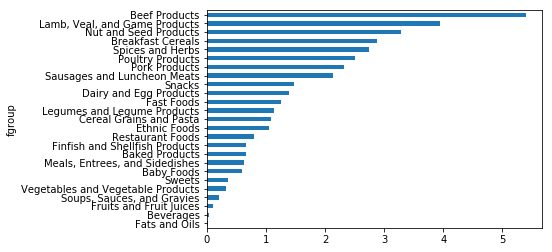

In [402]:
result['Zinc, Zn'].sort_values().plot(kind='barh')